In [1]:
import cofactors
import cobra
import seaborn as sb
import matplotlib.pyplot as pp
from pathlib import Path
import numpy as np

sb.set(style="whitegrid", context="paper")

# Loading and preparation

In [2]:
mitocore_file = Path("../external_data/mitocore/mitocore_v1.01.xml")
mappings = cofactors.create_mappings_ec_mitocore_from_xml(mitocore_file)

No mapping found for AMCOXO
No mapping found for AMCOXO2_MitoCore
ECs found for 102 reactions.
No ECs found for 0 reactions.


In [3]:
km_folder = Path("../generated_data/")
sabio_files = (km_folder / "sabiork_queries").glob("*")
brenda_files = (km_folder / "brenda_queries").glob("*")
kms_sabio = cofactors.read_sabiork(sabio_files)
kms_brenda = cofactors.read_brenda(brenda_files)
kms_brenda = kms_brenda[kms_brenda.value > 0.0]
kms_sabio = kms_sabio[kms_sabio.value > 0.0]

In [4]:
print('Kms in SabioRK:\t', len(kms_sabio))
print('Kms in Brenda:\t', len(kms_brenda))

Kms in SabioRK:	 1349
Kms in Brenda:	 1709


In [5]:
c_old = {'Cytosol': .11, 'Mitochondrion': .23}
c_low = {'Cytosol': .055, 'Mitochondrion': .023}
# KM values are set to [mM], so NAD concentrations should too

In [6]:
model = cobra.io.read_sbml_model(mitocore_file)
objectives = [r for r in model.reactions if r.id.startswith('OF_')]
model.objective = objectives[0]

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-27


SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of CHARGE in the notes element is discouraged, use fbc:charge in

In [7]:
model_brenda = cofactors.create_models_fva(model, mappings, kms_brenda, c_old, c_low)
model_sabio = cofactors.create_models_fva(model, mappings, kms_sabio, c_old, c_low)

Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpb9dnyqb1.lp
Reading time = 0.01 seconds
: 441 rows, 1110 columns, 4340 nonzeros
Read LP format model from file C:\Users\saute\AppData\Local\Temp\tmpv135ai4o.lp
Reading time = 0.00 seconds
: 441 rows, 1110 columns, 4340 nonzeros


In [8]:
sol_p = cobra.flux_analysis.parsimonious.pfba(model)
sol_p_sabio = cobra.flux_analysis.parsimonious.pfba(model_sabio)
sol_p_brenda = cobra.flux_analysis.parsimonious.pfba(model_brenda)

In [9]:
sol = model.optimize()
sol_sabio = model_sabio.optimize()
sol_brenda = model_brenda.optimize()

In [10]:
img_path = Path('../images/supplements')

# Objective values

Using FBA (maximum ATP production is objective):

In [11]:
print(f'SabioRK: {sol_sabio.objective_value:.2f}')
print(f'Brenda: {sol_brenda.objective_value:.2f}')

SabioRK: 96.37
Brenda: 77.15


Using pFBA (minimum total flux is objective):

In [12]:
print(f'SabioRK: {sol_p_sabio.objective_value:.2f}')
print(f'Brenda: {sol_p_brenda.objective_value:.2f}')


SabioRK: 1041.24
Brenda: 848.09


# Fluxes

Calculating fluxes using pFBA to get unique solutions.

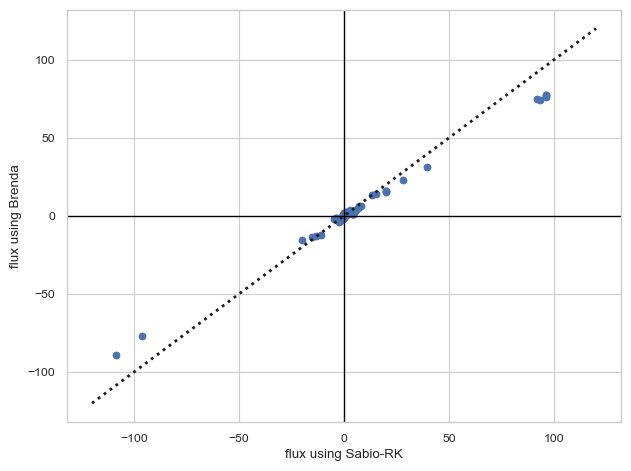

In [13]:
fig, ax = pp.subplots()
ax.scatter(sol_p_sabio.fluxes, sol_p_brenda.fluxes)
lim = 120
ax.plot([-lim,lim], [-lim,lim], color='k', linestyle=':', linewidth=2.)
ax.set_xlabel('flux using Sabio-RK'); ax.set_ylabel('flux using Brenda')
ax.axhline(0., color='black', linewidth=1.)
ax.axvline(0., color='black', linewidth=1.)
pp.tight_layout()

In [14]:
np.corrcoef(sol_p_sabio.fluxes, sol_p_brenda.fluxes)

array([[1.        , 0.99887244],
       [0.99887244, 1.        ]])

Fluxes are tightly correlated.